In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Check for CUDA

In [2]:
import torch
import numpy as np

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU...')
else:
  print('CUDA is available. Training on GPU')

CUDA is available. Training on GPU


Load the data

In [3]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets

# Number of subprocesses to use for data loading
num_workers = 0

# Number of samples per batch to load
batch_size = 32

# Percentage of training set to use for validation
valid_size = 0.2

# Transform train and test data
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading train and test data
train_data = datasets.ImageFolder('/content/drive/My Drive/intel-image-classification/seg_train',
                                 transform = transform_train)
test_data = datasets.ImageFolder('/content/drive/My Drive/intel-image-classification/seg_test',
                                transform = transform_test)

# Create validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                         sampler = train_sampler,
                                         num_workers = num_workers)
validloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                         sampler = valid_sampler,
                                         num_workers = num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                        num_workers = num_workers)

# Get the classes
import pathlib
root = pathlib.Path('/content/drive/My Drive/intel-image-classification/seg_train')
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Visualize a batch of training data

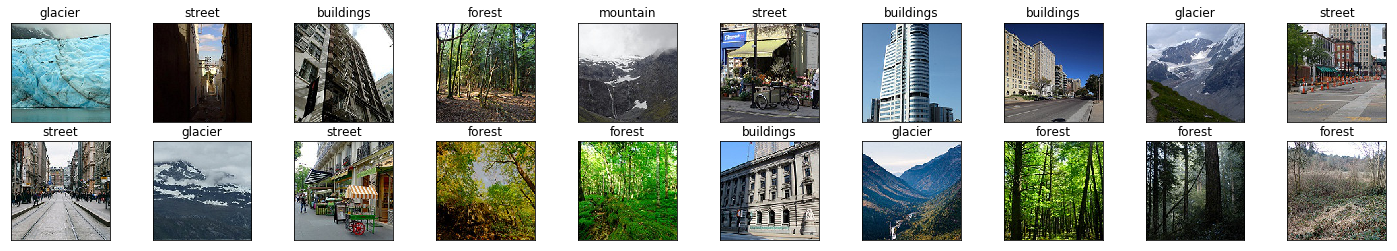

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  '''
  Function to un-normalize and display an image
  '''
  img = img/2 + 0.5 # un-normalize
  plt.imshow(np.transpose(img, (1, 2, 0))) # convert from tensor image
  
# Get a batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# Plot the images from the batch, along with corresponding labels
fig = plt.figure(figsize = (25, 4))

# Display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [5]:
print(images.shape)

(32, 3, 150, 150)


Create the Network Architecture

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN architecture
class IntelImageNet(nn.Module):
  def __init__(self):
    super(IntelImageNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 50, 3, padding = 1)
    self.conv2 = nn.Conv2d(50, 100, 3, padding = 1)
    self.conv3 = nn.Conv2d(100, 140, 3, padding = 1)
    self.conv4 = nn.Conv2d(140, 180, 3, padding = 1)
    self.conv5 = nn.Conv2d(180, 200, 3, padding = 1)
    self.pool = nn.MaxPool2d(5, 5)
    self.fc1 = nn.Linear(200, 100)
    self.fc2 = nn.Linear(100, 50)
    self.fc3 = nn.Linear(50, 6)
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = self.pool(F.relu(self.conv5(x)))
    x = x.view(x.size(0), -1) # flatten
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x
  
model = IntelImageNet()
print(model)

# Move tensors to GPU if CUDA is available
if train_on_gpu:
  model.cuda()

IntelImageNet(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(100, 140, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(140, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(180, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.5)
)


Specify Loss Function and Optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

Train the model

In [13]:
# Number of epochs to train the model
num_epochs = 50

valid_loss_min = np.Inf # track the change in validation loss

train_losses = []
valid_losses = []

for epoch in range(1, num_epochs+1):
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0
  
  #------------------
  # train the model
  #------------------
  model.train()
  for data, target in trainloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # calculate batch loss
    loss = criterion(output, target)
    
    # backward pass: compute gradient of the loss with respect to the 
    # model parameters
    loss.backward()
    
    # perform parameter update
    optimizer.step()
    
    # update training loss
    train_loss += loss.item()*data.size(0)
    
  #------------------
  # validate the model
  #------------------
  model.eval()
  for data, target in validloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    
    # update average validation loss
    valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(trainloader.sampler)
  valid_loss = valid_loss/len(validloader.sampler)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  
  # print training and validation stats
  print('Epoch: {} \tTraining Loss: {:.4f} \tValidation loss: {:.4f}'.format(
        epoch, train_loss, valid_loss))
  
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.4f} -> {:.4f}) \n Saving model...'.format(
          valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'intel_image_net.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.7001 	Validation loss: 1.4063
Validation loss decreased (inf -> 1.4063) 
 Saving model...
Epoch: 2 	Training Loss: 1.4090 	Validation loss: 1.2536
Validation loss decreased (1.4063 -> 1.2536) 
 Saving model...
Epoch: 3 	Training Loss: 1.2993 	Validation loss: 1.1700
Validation loss decreased (1.2536 -> 1.1700) 
 Saving model...
Epoch: 4 	Training Loss: 1.2382 	Validation loss: 1.1264
Validation loss decreased (1.1700 -> 1.1264) 
 Saving model...
Epoch: 5 	Training Loss: 1.1811 	Validation loss: 1.0932
Validation loss decreased (1.1264 -> 1.0932) 
 Saving model...
Epoch: 6 	Training Loss: 1.1511 	Validation loss: 1.0749
Validation loss decreased (1.0932 -> 1.0749) 
 Saving model...
Epoch: 7 	Training Loss: 1.0981 	Validation loss: 1.0329
Validation loss decreased (1.0749 -> 1.0329) 
 Saving model...
Epoch: 8 	Training Loss: 1.0643 	Validation loss: 1.0148
Validation loss decreased (1.0329 -> 1.0148) 
 Saving model...
Epoch: 9 	Training Loss: 1.0221 	Validation

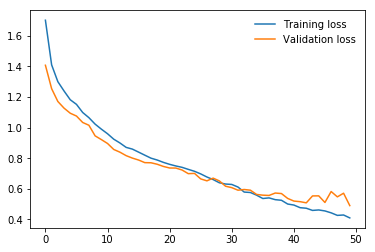

In [15]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.legend(frameon = False)
plt.show()

Load the model with the lowest validation loss

In [14]:
model.load_state_dict(torch.load('intel_image_net.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Test the trained network

In [18]:
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval()
for data, target in testloader:
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
    
  output = model(data)
  loss = criterion(output, target)
  
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output, 1)
  
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  
  for i in range(10):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
    
test_loss = test_loss / len(testloader.dataset)
print('Test loss: {:.4f}\n'.format(test_loss))

for i in range(6):
  if class_total[i] > 0:
    print('Test accuracy of %5s: %2d%% (%2d/%2d)' % (
          classes[i], 100*class_correct[i] / class_total[i], 
          np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest accuracy (Overall): %2d%% (%2d/%2d)' % (
    100.*np.sum(class_correct)/ np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test loss: 0.4546

Test accuracy of buildings: 82% (115/140)
Test accuracy of forest: 96% (145/150)
Test accuracy of glacier: 79% (135/170)
Test accuracy of mountain: 80% (132/165)
Test accuracy of   sea: 85% (135/158)
Test accuracy of street: 84% (132/157)

Test accuracy (Overall): 84% (794/940)


Prediction on the pred data set

Create a subfolder containing all the unlabeled images in seg_pred in order for PyTorch's ImageFolder to work.

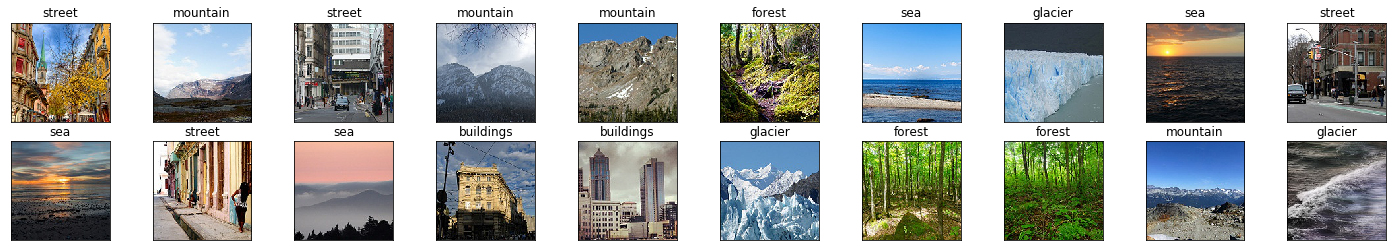

In [25]:
# Number of subprocesses to use for data loading
num_workers = 0

# Number of samples per batch to load
batch_size = 32

transform_pred = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

pred_data = datasets.ImageFolder('/content/drive/My Drive/intel-image-classification/seg_pred',
                                transform = transform_pred)

predloader = torch.utils.data.DataLoader(pred_data, batch_size = batch_size,
                                        num_workers = num_workers)

dataiter = iter(predloader)
images, no_labels = dataiter.next()
images.numpy()

if train_on_gpu:
  images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# Visualize predicted labels
fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx + 1, xticks = [], yticks = [])
  imshow(images.cpu()[idx])
  ax.set_title('{}'.format(classes[preds[idx]]))